<h2 align="center"> The University of Adelaide, School of Computer Science </h2>
<h1 align="center"><strong><b> Applied Natural Language Processing </b></strong></h1>
<h2 align="center"> Semester 1, 2023 Assignment 3: Building an aspect-based sentiment analysis algorithm based on syntactic parsing </h2>
<h2 align="center"> Author: Akide Liu </h2>
<h3 align="center"> Student ID: a1743748 </h3>


## 0. Import libraries and set up the environment

In [1]:
import os
import pprint
import time

import numpy as np

# import libs
from utils import *

# Matplotlib is a useful plotting library for python
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

2023-06-23 04:38:31.187647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-23 04:38:31.209734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 04:38:31.554905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-23 04:38:32.301948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

## 1. Write code for data loading and text preprocessing 5%

## 1.1 Load the data

In [2]:
# Read the CSV file
xml_data = load_xml('Restaurants.xml')


In [3]:
len(xml_data.getchildren())

/tmp/ipykernel_884448/1487888614.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  len(xml_data.getchildren())


3041

In [4]:
xml_data.getchildren()[0]

/tmp/ipykernel_884448/872354137.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  xml_data.getchildren()[0]


<Element 'sentence' at 0x7fdb48b84e50>

In [5]:
get_xml_structure(xml_data[0])

sentence
  text
  aspectTerms
    aspectTerm
  aspectCategories
    aspectCategory


In [6]:
data = parse_xml_to_df(xml_data)

In [7]:
pprint.pprint(data[0])
len(data)

{'aspect_categories': [{'category': 'service', 'polarity': 'negative'}],
 'aspect_terms': [{'from': '8',
                   'polarity': 'negative',
                   'term': 'staff',
                   'to': '13'}],
 'id': '3121',
 'text': 'But the staff was so horrible to us.'}


3041

In [8]:
text_data = [d['text'] for d in data]

In [9]:
text_data[0:5]

['But the staff was so horrible to us.',
 "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.",
 "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.",
 'Where Gabriela personaly greets you and recommends you what to eat.',
 "For those that go once and don't enjoy it, all I can say is that they just don't get it."]

In [10]:

def generate_mask_for_text(text_data, inner_data):
    # Load the spacy tokenizer
    # Tokenize the sentence
    doc = text_data[0]

    # Initialize a mask with all zeros (same length as number of tokens)
    mask = [0] * len(doc)

    # iterate over each aspect term
    for term in inner_data[0]['aspect_terms']:
        start, end = int(term['from']), int(term['to'])
        # iterate over the tokens in the doc
        for i, token in enumerate(doc):
            if start <= i < end:
                mask[i] = 1

    # generate the inner data by zipping tokens and their corresponding masks
    inner_data = list(zip(doc, mask))

    # create a string of all characters
    string = "".join([str(char) for char, mask in inner_data])

    words = string.split()
    mask_values = [mask for char, mask in inner_data]

    word_masks = []
    current_index = 0
    for word in words:
        word_masks.append(mask_values[current_index:current_index + len(word)])
        current_index += len(word) + 1

    word_mask_values = [sum(mask) > 0 for mask in word_masks]

    out_words = [word for word in words]
    out_masks = [mask for mask in word_mask_values]

    return out_words, out_masks


In [11]:
generate_mask_for_text(text_data, data)

(['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 [False, False, True, False, False, False, False, False])

In [12]:
for d in data:
    d['words'], d['mask'] = generate_mask_for_text(text_data, data)

In [13]:
data[2]

{'id': '1634',
 'text': "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.",
 'aspect_terms': [{'term': 'food',
   'polarity': 'positive',
   'from': '4',
   'to': '8'},
  {'term': 'kitchen', 'polarity': 'positive', 'from': '55', 'to': '62'},
  {'term': 'menu', 'polarity': 'neutral', 'from': '141', 'to': '145'}],
 'aspect_categories': [{'category': 'food', 'polarity': 'positive'}],
 'words': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 'mask': [False, False, True, False, False, False, False, False]}

In [14]:
# load a pre-trained english language model
nlp = spacy.load("en_core_web_sm")

In [15]:
doc = nlp(data[0].text)

In [16]:
parsed = pd.DataFrame(columns=["noun_chunk", "root", "dep", "head"])
for chunk in doc.noun_chunks:
    row = pd.DataFrame([{
        "noun_chunk": chunk.text,
        "root": chunk.root.text,
        "dep": chunk.root.dep_,
        "head": chunk.root.head.text
    }])
    parsed = pd.concat([parsed, row], axis=0, ignore_index=True)

print(doc)
parsed.head()

But the staff was so horrible to us.


,noun_chunk,root,dep,head
0,the staff,staff,nsubj,was
1,us,us,pobj,to


In [17]:
# visualise the dependency tree with arcs
displacy.render(doc, style="dep", jupyter=True)

In [18]:
from nltk.corpus import opinion_lexicon

# Now you can access the positive and negative word lists like this
positive_words = opinion_lexicon.positive()
negative_words = opinion_lexicon.negative()

# Print the first 10 positive words
print(positive_words[:10])

# Print the first 10 negative words
print(negative_words[:10])


['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [19]:
print(len(data))
data = [d for d in data if len(d['aspect_terms']) > 0]
print(len(data))

3041
2021


## 2. Rule System

In [77]:
from random import random
from textblob import TextBlob

class AspectSentimentAnalyzer:
    def __init__(self, sentences, aspect_terms, debug=False):
        self.nlp = spacy.load("en_core_web_sm")
        self.poswords = set(opinion_lexicon.positive())
        self.negwords = set(opinion_lexicon.negative())
        self.sentences = sentences
        self.aspect_terms = aspect_terms
        self.debug = debug
        # [{'term': 'staff', 'polarity': 'negative', 'from': '8', 'to': '13'}]
        self.sentiment_map = edict(
            positive=1,
            negative=-1,
            neutral=0
        )
        self.new_acpect_term_state = {}



    def debug_print(self, token):
        if self.debug:
            print(token.text, token.dep_, token.pos_, token.head.text, token.head.pos_,
                  [child for child in token.children])

    def check_correctness(self, state):

        state = state.copy()
        for s,v in state.items():
            if abs(v) > 0:
                state[s] = 1 if v > 0 else -1
        for term in self.aspect_terms:
            if ' ' in term['term']:
                continue
            if state[term['term']] != self.sentiment_map[f"{term['polarity']}"]:
                print(state, self.aspect_terms)
                return False
        else:
            return True

    def analyze(self, number_of_rules=100):
        doc = self.nlp(self.sentences)
        self.aspect_terms_tokens = [term.term.lower() for term in self.aspect_terms]

        # modfied aspect terms
        for ast in self.aspect_terms_tokens:
            if ' ' in ast:
                self.aspect_terms_tokens.remove(ast)
                self.aspect_terms_tokens.extend(ast.split())
        self.apply_rules(doc, number_of_rules)
        return self.new_acpect_term_state


    def show_dependency_tree(self):

        displacy.render(self.nlp(self.sentences), style="dep", jupyter=True)

    def _change_state(self, text, token, neg=False):
        # if text.lower() in self.poswords:
        #     self.new_acpect_term_state[token.text] += self.sentiment_map.positive
        # elif text.lower() in self.negwords:
        #     self.new_acpect_term_state[token.text] += self.sentiment_map.negative
        # else:
        #     self.new_acpect_term_state[token.text] += self.sentiment_map.neutral
        #
        # if neg:
        #     self.new_acpect_term_state[token.text] += -1
        value = TextBlob(text).sentiment.polarity
        print(f"rule touched for {token.text} with value {value}") if self.debug else None
        #
        if neg:
            value *= -1
        #
        self.new_acpect_term_state[token.text] += value


    def apply_rules(self, doc , number_of_rules=100):

        rule_list = [self.rule1, self.rule2, self.rule3, self.rule4, self.rule5, self.rule6, self.rule7, self.rule8,
                     self.rule9, self.rule10, self.rule11]
        number_of_rules = min(number_of_rules, len(rule_list))
        for token in doc:
            if token.text.lower() in self.aspect_terms_tokens:
                self.new_acpect_term_state[token.text] = 0
                for rule in rule_list[:number_of_rules]:
                    rule(token)

    def rule1(self, token):
        for child in token.children:
            self.debug_print(child)
            if child.dep_ == "amod":
                print(f"rule1 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)

    def rule2(self, token):
        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "acomp":
                print(f"rule2 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)

        ele = token.head
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)

    def rule3(self, token):
        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "amod":
                print(f"rule3 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)

        ele = token.head
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)

    def rule4(self, token):
        def process_child(child):
            if child.pos_ == 'VERB':
                for j in child.children:
                    if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                        print(f"rule4 touched for {token.text}") if self.debug else None
                        self._change_state(j.text, token)

        ele = token.head
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)

    def rule5(self, token):
        def process_child(child):
            if child.pos_ == 'VERB':
                for j in child.children:
                    if j.dep_ == 'advmod' and j.pos_ == 'ADV':
                        print(f"rule5 touched for {token.text}") if self.debug else None
                        self._change_state(j.text, token)

        ele = token.head
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)


    def rule6(self, token):
        def process_child(child):
            if child.pos_ == 'NOUN':
                for j in child.lefts:
                    if j.dep_ == 'compound':
                        print(f"rule6 touched for {token.text}") if self.debug else None
                        self._change_state(j.text, token)

        ele = token.head
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)


    def rule7(self, token):
        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "amod" or child.dep_ == "dobj":
                print(f"rule7 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)


        ele = token.head.head
        print(f"rule 7 ele : {ele}") if self.debug else None
        for child in ele.children:
            process_child(child)
            # Recursively process the children of each child
            for sub_child in child.children:
                process_child(sub_child)

                for sub_sub_child in sub_child.children:
                    process_child(sub_sub_child)

    def rule8(self, token):
        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "neg":
                print(f"rule8 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)
                # Recursively process the children of each child
                for sub_child in child.children:
                    process_child(sub_child)


        ele = token.head.head.head
        print(f"rule 8 ele : {ele}") if self.debug else None
        for child in ele.children:
            process_child(child)


    def rule9(self, token):

        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "acomp":
                print(f"rule9 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)
                # Recursively process the children of each child
                for sub_child in child.children:
                    # if sub_child.dep_ == "acomp":
                        process_child(sub_child)

        ele = token.head.head
        print(f"rule 9 ele : {ele}") if self.debug else None
        for child in ele.children:
            process_child(child)


    def rule10(self, token):

        ele = token.head.head
        self.debug_print(ele)
        print(f"rule 10 ele : {ele}") if self.debug else None
        if ele.pos_ == "NOUN":
            self._change_state(ele.text, token)


    def rule11(self, token):

        def process_child(child):
            self.debug_print(child)
            if child.dep_ == "advmod":
                print(f"rule11 touched for {token.text}") if self.debug else None
                self._change_state(child.text, token)
                # Recursively process the children of each child
                for sub_child in child.children:
                    process_child(sub_child)

        ele = token.head.head
        self.debug_print(ele)
        print(f"rule 11 ele : {ele}") if self.debug else None
        # if ele.pos_ == "NOUN":
        self._change_state(ele.text, token)
        for child in ele.children:
            process_child(child)



In [78]:
"out" in opinion_lexicon.negative()

False

In [79]:
TextBlob("quite expert").sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

## 2.1 Case 1

In [80]:
data[0]

{'id': '3121',
 'text': 'But the staff was so horrible to us.',
 'aspect_terms': [{'term': 'staff',
   'polarity': 'negative',
   'from': '8',
   'to': '13'}],
 'aspect_categories': [{'category': 'service', 'polarity': 'negative'}],
 'words': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 'mask': [False, False, True, False, False, False, False, False]}

In [81]:
analyzer = AspectSentimentAnalyzer(data[0].text, data[0]['aspect_terms'], debug=True)
count_ne = analyzer.show_dependency_tree()
# print(count_ne)

In [82]:
out = analyzer.analyze()

the det DET staff NOUN []
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
rule2 touched for staff
rule touched for staff with value -1.0
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
. punct PUNCT was AUX []
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
. punct PUNCT was AUX []
rule 7 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
us pobj PRON to ADP []
. punct PUNCT was AUX []
rule 8 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
horrible acomp ADJ was AUX [so, to]
. punct PUNCT was AUX []
rule 9 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
horrible acomp ADJ was AUX [so, to]
rule9 touched for staff


In [83]:
print(analyzer.check_correctness(out))

True


## 2.2 Explore System

In [90]:

skip = [4, 7, 10, 11]

def check_until_failure(inner_data):
    for i,d in enumerate(inner_data):
        if i in skip:
            continue
        analyzer = AspectSentimentAnalyzer(d.text, d['aspect_terms'], debug=True)
        out = analyzer.analyze()
        # assert analyzer.check_correctness(out), f"error at index {i}, with {out}, data : {d}"
        if not analyzer.check_correctness(out):
            print(f"error at index {i}, with {out}, data : {d}")
            print("-"*20)

            print(f"give you the sentence like this : '{d.text}', and we need to Building an aspect-based sentiment analysis algorithm based on syntactic parsing for terms : [{[t['term'] for t in d.aspect_terms]}], you need to do syntactic parsing by your self first, then give me the rule by spacy ")
            break
        print(f"passed {i}")

check_until_failure(data)

the det DET staff NOUN []
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
rule2 touched for staff
rule touched for staff with value -1.0
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
. punct PUNCT was AUX []
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
. punct PUNCT was AUX []
rule 7 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
the det DET staff NOUN []
horrible acomp ADJ was AUX [so, to]
so advmod ADV horrible ADJ []
to prep ADP horrible ADJ [us]
us pobj PRON to ADP []
. punct PUNCT was AUX []
rule 8 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
horrible acomp ADJ was AUX [so, to]
. punct PUNCT was AUX []
rule 9 ele : was
But cc CCONJ was AUX []
staff nsubj NOUN was AUX [the]
horrible acomp ADJ was AUX [so, to]
rule9 touched for staff


## 2.3 Case 2

In [50]:
'outstanding' in analyzer.poswords

True

In [52]:
index = 2
analyzer = AspectSentimentAnalyzer(data[index].text, data[index]['aspect_terms'], debug=True)
analyzer.show_dependency_tree()

In [53]:
analyzer.analyze()

The det Bagels PROPN []
Bagels nsubj have VERB [The]
The det Bagels PROPN []
taste dobj have VERB [an, outstanding, with]
an det taste NOUN []
outstanding amod taste NOUN []
with prep taste NOUN [texture]
The det Bagels PROPN []
The det Bagels PROPN []
rule 7 ele : gummy
have ccomp gummy ADJ [Bagels, taste]
Bagels nsubj have VERB [The]
The det Bagels PROPN []
taste dobj have VERB [an, outstanding, with]
rule7 touched for Bagels
an det taste NOUN []
outstanding amod taste NOUN []
rule7 touched for Bagels
with prep taste NOUN [texture]
, punct gummy ADJ []
chewy nsubj gummy ADJ [both, yet]
both det chewy NOUN []
yet advmod chewy NOUN []
not neg gummy ADJ []
. punct gummy ADJ []
rule 8 ele : gummy
have ccomp gummy ADJ [Bagels, taste]
, punct gummy ADJ []
chewy nsubj gummy ADJ [both, yet]
not neg gummy ADJ []
rule8 touched for Bagels
. punct gummy ADJ []


{'Bagels': -0.5}

## 2.4 Case 3

In [25]:
index = 10
data[index]

{'id': '296',
 'text': 'They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.',
 'aspect_terms': [{'term': 'toast',
   'polarity': 'negative',
   'from': '41',
   'to': '46'},
  {'term': 'mayonnaise', 'polarity': 'negative', 'from': '18', 'to': '28'},
  {'term': 'bacon', 'polarity': 'negative', 'from': '126', 'to': '131'},
  {'term': 'cheese', 'polarity': 'neutral', 'from': '73', 'to': '79'},
  {'term': 'ingredients', 'polarity': 'negative', 'from': '57', 'to': '68'},
  {'term': 'plate', 'polarity': 'neutral', 'from': '170', 'to': '175'},
  {'term': 'omelet', 'polarity': 'neutral', 'from': '86', 'to': '92'}],
 'aspect_categories': [{'category': 'food', 'polarity': 'negative'}],
 'words': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 'mask': [False, False, True, False, False, False, False, False]}

In [26]:
analyzer = AspectSentimentAnalyzer(data[index].text, data[index]['aspect_terms'], debug=True)
analyzer.show_dependency_tree()

In [27]:
analyzer.analyze()

They nsubj have VERB []
did aux have VERB []
not neg have VERB []
mayonnaise dobj have VERB []
, punct have VERB []
forgot conj have VERB [toast, ,, left]
toast dobj forgot VERB [our]
, punct forgot VERB []
left conj forgot VERB [out, ingredients]
was conj have VERB [cooked]
cooked acomp was AUX [over, crumbled]
rule2 touched for mayonnaise
. punct have VERB []
rule 7 ele : have
They nsubj have VERB []
did aux have VERB []
not neg have VERB []
mayonnaise dobj have VERB []
rule7 touched for mayonnaise
, punct have VERB []
forgot conj have VERB [toast, ,, left]
toast dobj forgot VERB [our]
rule7 touched for mayonnaise
our poss toast NOUN []
, punct forgot VERB []
left conj forgot VERB [out, ingredients]
out prt left VERB []
ingredients dobj left VERB [(, cheese, ,, below]
rule7 touched for mayonnaise
was conj have VERB [cooked]
cooked acomp was AUX [over, crumbled]
over advmod cooked VERB [so]
crumbled ccomp cooked VERB [it, on, touched]
. punct have VERB []
rule 8 ele : have
They nsubj 

{'mayonnaise': -1,
 'toast': -1,
 'ingredients': -1,
 'cheese': 0,
 'omelet': 0,
 'bacon': 1,
 'plate': 0}

## 2.5 Case 4

In [92]:
index = 12
data[index]

{'id': '2200',
 'text': 'The design and atmosphere is just as good.',
 'aspect_terms': [{'term': 'design',
   'polarity': 'positive',
   'from': '4',
   'to': '10'},
  {'term': 'atmosphere', 'polarity': 'positive', 'from': '15', 'to': '25'}],
 'aspect_categories': [{'category': 'ambience', 'polarity': 'positive'}],
 'words': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 'mask': [False, False, True, False, False, False, False, False]}

In [93]:
analyzer = AspectSentimentAnalyzer(data[index].text, data[index]['aspect_terms'], debug=True)
analyzer.show_dependency_tree()

In [94]:
analyzer.analyze()

The det design NOUN []
and cc design NOUN []
atmosphere conj design NOUN []
design nsubj is AUX [The, and, atmosphere]
The det design NOUN []
and cc design NOUN []
atmosphere conj design NOUN []
good acomp is AUX [just, as]
rule2 touched for design
rule touched for design with value 0.7
just advmod good ADJ []
as advmod good ADJ []
. punct is AUX []
The det design NOUN []
and cc design NOUN []
atmosphere conj design NOUN []
The det design NOUN []
and cc design NOUN []
atmosphere conj design NOUN []
rule5 touched for design
rule touched for design with value 0.0
rule 7 ele : is
design nsubj is AUX [The, and, atmosphere]
The det design NOUN []
and cc design NOUN []
atmosphere conj design NOUN []
good acomp is AUX [just, as]
just advmod good ADJ []
as advmod good ADJ []
. punct is AUX []
rule 8 ele : is
design nsubj is AUX [The, and, atmosphere]
good acomp is AUX [just, as]
. punct is AUX []
rule 9 ele : is
design nsubj is AUX [The, and, atmosphere]
good acomp is AUX [just, as]
rule9 touc

{'design': 1.4, 'atmosphere': 0.7}

## 2.6 Case 5

In [119]:
index = 13
data[index]

{'id': '3195',
 'text': 'He has visited Thailand and is quite expert on the cuisine.',
 'aspect_terms': [{'term': 'cuisine',
   'polarity': 'positive',
   'from': '51',
   'to': '58'}],
 'aspect_categories': [{'category': 'food', 'polarity': 'positive'}],
 'words': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us.'],
 'mask': [False, False, True, False, False, False, False, False]}

In [120]:
analyzer = AspectSentimentAnalyzer(data[index].text, data[index]['aspect_terms'], debug=True)
analyzer.show_dependency_tree()

In [121]:
analyzer.analyze()

the det DET cuisine NOUN []
cuisine pobj NOUN on ADP [the]
the det DET cuisine NOUN []
the det DET cuisine NOUN []
the det DET cuisine NOUN []
rule 7 ele : expert
quite advmod ADV expert NOUN []
on prep ADP expert NOUN [cuisine]
cuisine pobj NOUN on ADP [the]
the det DET cuisine NOUN []
rule 8 ele : is
expert attr NOUN is AUX [quite, on]
rule 9 ele : expert
quite advmod ADV expert NOUN []
on prep ADP expert NOUN [cuisine]
expert attr NOUN is AUX [quite, on]
rule 10 ele : expert
rule touched for cuisine with value 0.0
expert attr NOUN is AUX [quite, on]
rule 11 ele : expert
rule touched for cuisine with value 0.0
quite advmod ADV expert NOUN []
rule11 touched for cuisine
rule touched for cuisine with value 0.0
on prep ADP expert NOUN [cuisine]


{'cuisine': 0.0}

## 3. Evaluate

In [62]:
def calculate_precision(detected_true, detected):
    return detected_true / detected if detected else 0


def calculate_recall(detected_true, total):
    return detected_true / total if total else 0


def calculate_f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

from tqdm.notebook import tqdm
number_of_rules = 100
def analyze_sentiment(analyzer, text, aspect_terms):
    """
    Analyzes the sentiment of given text and aspect terms.

    :param analyzer: An instance of AspectSentimentAnalyzer
    :param text: The text to analyze
    :param aspect_terms: The aspect terms for analysis
    :return: A dictionary mapping aspect terms to sentiment scores
    """
    # Get sentiment scores from the analyzer
    out = analyzer.analyze(number_of_rules)

    # Normalize sentiment scores to 1, -1, or 0
    state = out.copy()
    for s,v in state.items():
        if abs(v) > 0:
            state[s] = 1 if v > 0 else -1


    return state


from concurrent.futures import ThreadPoolExecutor

def process_item(arg):
    (d, target, target_sentiment, eval_class) = arg
    """
    Process a single item from the dataset.
    """
    # Initialize sentiment analyzer
    analyzer = eval_class(d.text, d['aspect_terms'], debug=False)

    # Analyze sentiment
    state = analyze_sentiment(analyzer, d.text, d['aspect_terms'])

    # Characters to check for in aspect terms
    special_chars = {' ', '-'}

    # Initialize counters for this item
    pos = 0
    fp = 0
    tp = 0

    # Loop through each aspect term in the data point
    for term in d['aspect_terms']:
        # Increment positive counter if aspect term has target sentiment
        if term['polarity'] == target:
            pos += 1

        # If aspect term doesn't have spaces or hyphens and has the target sentiment
        if not any(char in term['term'] for char in special_chars) and term['polarity'] == target:
            # Increment false positive counter if state doesn't match target sentiment
            if state.get(term['term'], -10) != target_sentiment:
                fp += 1
                break
            else:
                # Increment true positive counter
                tp += 1

    # Return counters for this item
    return pos, fp, tp


def evaluate(data, target="positive", num_threads=16, eval_class=AspectSentimentAnalyzer):
    """
    Evaluates the precision, recall, and f1 score of sentiment analysis on given data using multiple threads.
    """
    # Ensure the target is a valid sentiment
    assert target in ["positive", "negative", "neutral"], "target must be either positive, negative, or neutral"

    # Initialize counters for true positives, false positives, and positive cases
    counter = dict(
        tp=0,
        fp=0,
        pos=0
    )

    # Dummy analyzer to get the sentiment map
    dummy_analyzer = AspectSentimentAnalyzer("", [], debug=False)
    target_sentiment = dummy_analyzer.sentiment_map[target]

    # # Use a thread pool to process items in parallel
    # with ThreadPoolExecutor(max_workers=num_threads) as executor:
    #     # Process each item and update counters
    #     for pos, fp, tp in executor.map(lambda d: process_item(d, target, target_sentiment), data):
    #         counter['pos'] += pos
    #         counter['fp'] += fp
    #         counter['tp'] += tp
    out = []
    args = [(d, target, target_sentiment, eval_class) for d in data]
    if num_threads == 1:
        for arg in tqdm(args):
            out.append(process_item(arg))
    else:
        out = track_parallel_progress(process_item, args, num_threads)

    for pos, fp, tp in out:
        counter['pos'] += pos
        counter['fp'] += fp
        counter['tp'] += tp
    # Calculate precision, recall, and f1 score
    precision = calculate_precision(counter['tp'], counter['tp'] + counter['fp'])
    recall = calculate_recall(counter['tp'], counter['pos'])
    f1_score = calculate_f1_score(precision, recall)

    # Return results as a dictionary
    return dict(
        precision=precision,
        recall=recall,
        f1_score=f1_score
    )


In [98]:
evaluate(data, target="positive")

{'f1_score': 0.6165279429250893,
 'precision': 0.7359829666430092,
 'recall': 0.5304347826086957}


In [100]:
evaluate(data, target="negative")

{'f1_score': 0.544054747647562,
 'precision': 0.6138996138996139,
 'recall': 0.48847926267281105}


In [101]:
evaluate(data, target="neutral")

{'f1_score': 0.5611650485436893,
 'precision': 0.6465324384787472,
 'recall': 0.4957118353344768}


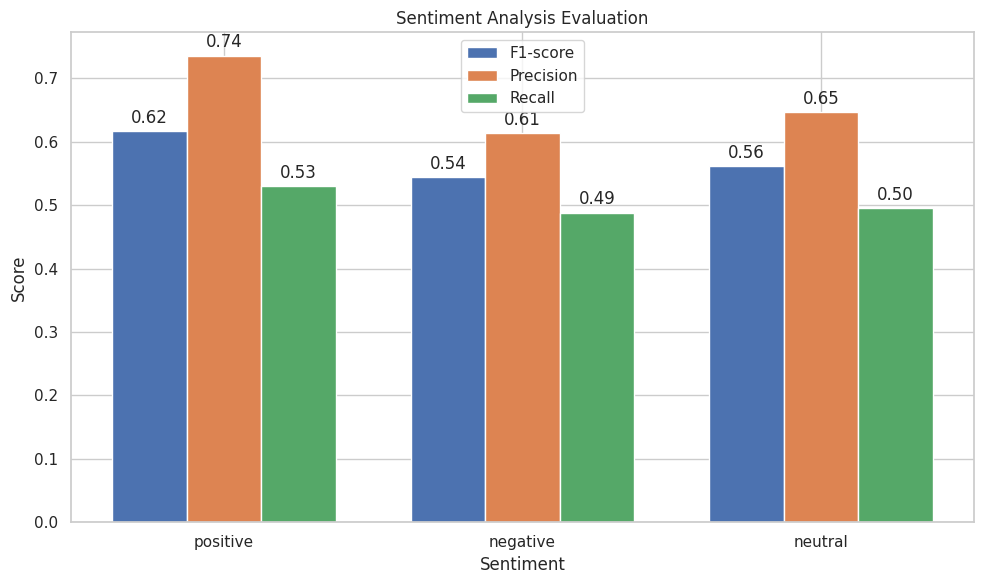

In [105]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    'positive': {
        'f1_score': 0.6165279429250893,
        'precision': 0.7359829666430092,
        'recall': 0.5304347826086957
    },
    'negative': {
        'f1_score': 0.544054747647562,
        'precision': 0.6138996138996139,
        'recall': 0.48847926267281105
    },
    'neutral': {
        'f1_score': 0.5611650485436893,
        'precision': 0.6465324384787472,
        'recall': 0.4957118353344768
    }
}

labels = list(data.keys())
scores = list(data.values())

f1_scores = [score['f1_score'] for score in scores]
precisions = [score['precision'] for score in scores]
recalls = [score['recall'] for score in scores]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, f1_scores, width, label='F1-score')
rects2 = ax.bar(x, precisions, width, label='Precision')
rects3 = ax.bar(x + width, recalls, width, label='Recall')

# Function to add labels on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Sentiment Analysis Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


In [66]:
results = []
for i in np.arange(1, 12, 1):
    number_of_rules = i
    print(f"Evaluating with {number_of_rules} rules")
    result = dict(
        number_of_rules=number_of_rules,
        positive=evaluate(data, target="positive"),
        negative=evaluate(data, target="negative"),
        neutral=evaluate(data, target="neutral")
    )
    results.append(result)

Evaluating with 1 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 2 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 3 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 4 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 5 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 6 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 7 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 8 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 9 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 10 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

Evaluating with 11 rules


  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

  0%|          | 0/2021 [00:00<?, ?it/s]

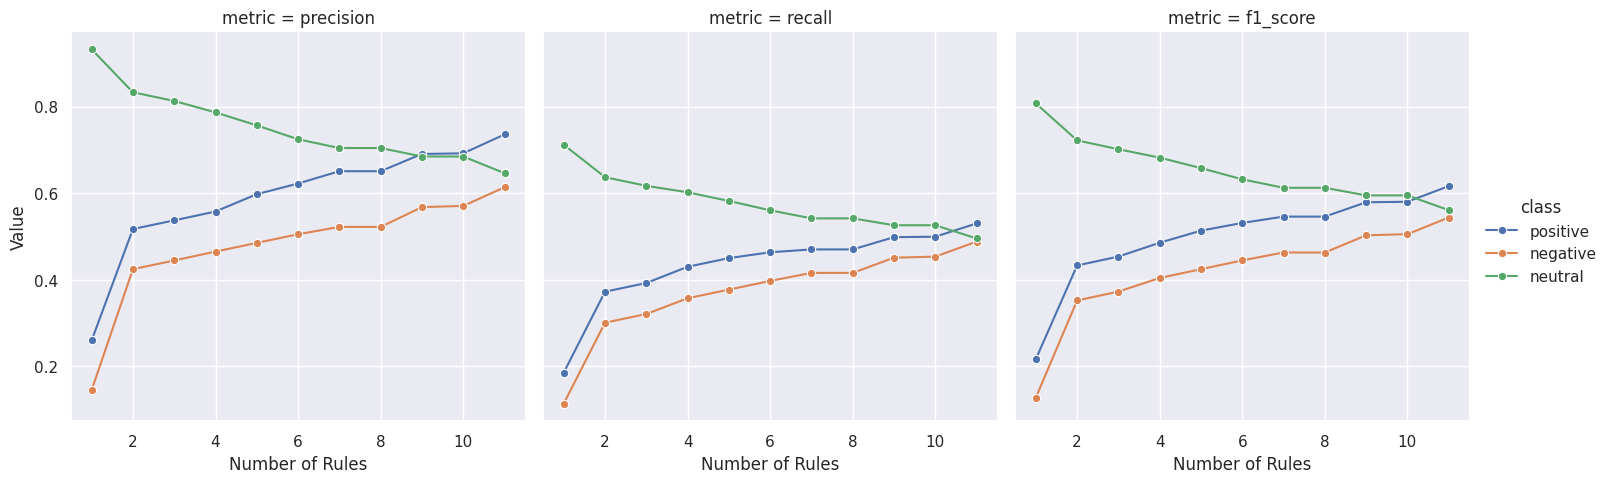

In [94]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Your data

def plot_rule_based_results(res):

    # Flatten the data into a DataFrame
    flattened_data = []
    for entry in res:
        number_of_rules = entry["number_of_rules"]
        for class_name, metrics in entry.items():
            if class_name != "number_of_rules":
                for metric_name, value in metrics.items():
                    flattened_data.append({
                        "number_of_rules": number_of_rules,
                        "class": class_name,
                        "metric": metric_name,
                        "value": value
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)

    # Create a FacetGrid to display multiple plots
    g = sns.FacetGrid(df, col="metric", hue="class", height=5)
    g.map_dataframe(sns.lineplot, x="number_of_rules", y="value", marker="o")
    g.set_axis_labels("Number of Rules", "Value")
    g.add_legend()

    # Show plot
    plt.show()


# # dump results to file
# with open("results.json", "w") as f:
#     json.dump(results, f, indent=4)
plot_rule_based_results(results)

In [92]:
results

[{'negative': {'f1_score': 0.1279707495429616,
               'precision': 0.14522821576763487,
               'recall': 0.11437908496732026},
  'neutral': {'f1_score': 0.8076572470373746,
              'precision': 0.9326315789473684,
              'recall': 0.7122186495176849},
  'number_of_rules': 1,
  'positive': {'f1_score': 0.2168413444163354,
               'precision': 0.26019080659150046,
               'recall': 0.18587360594795538}},
 {'negative': {'f1_score': 0.3524441015378134,
               'precision': 0.424809619238477,
               'recall': 0.30114467408585055},
  'neutral': {'f1_score': 0.7222222222222222,
              'precision': 0.8333333333333334,
              'recall': 0.6372549019607843},
  'number_of_rules': 2,
  'positive': {'f1_score': 0.43336591723688495,
               'precision': 0.5175097276264592,
               'recall': 0.3727578475336323}},
 {'negative': {'f1_score': 0.37299416282560305,
               'precision': 0.44480961923847695,
        

## 4. Bert Based Sentiment Analysis

In [69]:
model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

aspects = ["food", "service"]
text = "The food was great but the service was terrible."
sentiment_aspect = {}
for aspect in aspects:
  inputs = tokenizer(text, aspect, return_tensors="pt")

  with torch.inference_mode():
    outputs = model(**inputs)

  scores = F.softmax(outputs.logits[0], dim=-1)
  label_id = torch.argmax(scores).item()
  sentiment_aspect[aspect] = (model.config.id2label[label_id], scores[label_id].item())

print(sentiment_aspect)

/home/akide/anaconda3/envs/ANLP/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


{'food': ('Positive', 0.9973154664039612), 'service': ('Negative', 0.9935430288314819)}


In [70]:
class BertAspectSentimentAnalyzer(AspectSentimentAnalyzer):
    def __init__(self, sentences, aspect_terms, debug=False):
        super().__init__(sentences, aspect_terms, debug)
        self.model_name = "yangheng/deberta-v3-base-absa-v1.1"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)


    def analyze(self, number_of_rules=1):
        """
        Analyzes the sentiment of given text and aspect terms.

        :return: A dictionary mapping aspect terms to sentiment scores
        """
        # Initialize sentiment scores
        sentiment = {}

        for aspect in self.aspect_terms:
            # Get sentiment for aspect term
            inputs = self.tokenizer(self.sentences, aspect['term'], return_tensors="pt").to(self.device)
            with torch.inference_mode():
                outputs = self.model(**inputs)

                scores = F.softmax(outputs.logits[0], dim=-1)
                label_id = torch.argmax(scores).item()
                sentiment[aspect['term']] = (model.config.id2label[label_id], scores[label_id].item())

        # print(sentiment)
        for asp_k, asp_v in sentiment.items():
            self.new_acpect_term_state[asp_k] = self.sentiment_map[asp_v[0].lower()]

        return self.new_acpect_term_state


In [71]:
analyzer = BertAspectSentimentAnalyzer(data[0].text, data[0]['aspect_terms'], debug=True)
analyzer.analyze()

{'staff': -1}

In [72]:
os.environ["TOKENIZERS_PARALLELISM"] = "True"
evaluate(data, target="positive", eval_class=BertAspectSentimentAnalyzer, num_threads=1)

  0%|          | 0/2021 [00:00<?, ?it/s]

{'precision': 0.8885850991114149,
 'recall': 0.6448412698412699,
 'f1_score': 0.7473411899971256}

In [73]:
evaluate(data, target="negative", eval_class=BertAspectSentimentAnalyzer, num_threads=1)

  0%|          | 0/2021 [00:00<?, ?it/s]

{'precision': 0.8737541528239202,
 'recall': 0.699468085106383,
 'f1_score': 0.776957163958641}

In [74]:
evaluate(data, target="neutral", eval_class=BertAspectSentimentAnalyzer, num_threads=1)

  0%|          | 0/2021 [00:00<?, ?it/s]

{'precision': 0.8763102725366876,
 'recall': 0.6818923327895595,
 'f1_score': 0.7669724770642201}

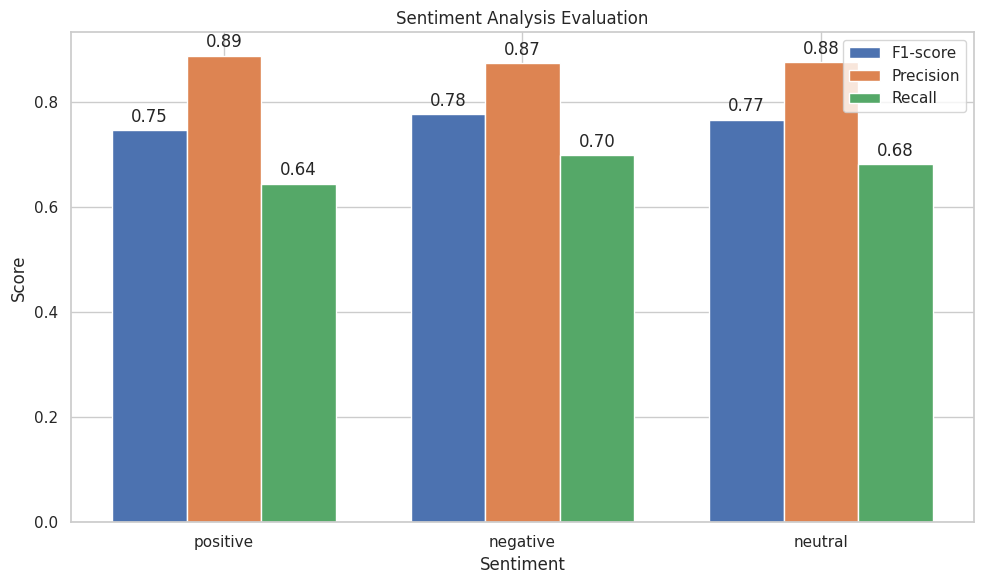

In [106]:
import matplotlib.pyplot as plt
import numpy as np

data = {
  'positive':
      {'precision': 0.8885850991114149,
        'recall': 0.6448412698412699,
        'f1_score': 0.7473411899971256},
'negative': {
    'precision': 0.8737541528239202,
    'recall': 0.699468085106383,
    'f1_score': 0.776957163958641},
  'neutral':{
        'precision': 0.8763102725366876,
        'recall': 0.6818923327895595,
        'f1_score': 0.7669724770642201}}

labels = list(data.keys())
scores = list(data.values())

f1_scores = [score['f1_score'] for score in scores]
precisions = [score['precision'] for score in scores]
recalls = [score['recall'] for score in scores]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, f1_scores, width, label='F1-score')
rects2 = ax.bar(x, precisions, width, label='Precision')
rects3 = ax.bar(x + width, recalls, width, label='Recall')

# Function to add labels on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

ax.set_xlabel('Sentiment')
ax.set_ylabel('Score')
ax.set_title('Sentiment Analysis Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


## Save the Notebook

In [108]:
import glob

files = glob.glob('*.py')
# outputs = glob.glob('*.csv')
outputs = glob.glob('*.png')
outputs += glob.glob('*.PNG')
# outputs += glob.glob('*.txt')
# outputs = glob.glob('figures/*')
# outputs.append('download.sh')
import jovian

jovian.commit(project='akide/ANLP_assignment_3',
              filename='ANLP_A3.ipynb',
              files=files,
              new_project=False,
              outputs=outputs,
              environment='auto')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "akide/anlp-assignment-3" on https://jovian.com/
[jovian] Capturing environment..


/bin/sh: 1: conda: not found
/bin/sh: 1: conda: not found
[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"


[jovian] Uploading additional files...
[jovian] Committed successfully! https://jovian.com/akide/anlp-assignment-3


'https://jovian.com/akide/anlp-assignment-3'